In [25]:

import warnings
warnings.simplefilter(action='ignore')
from numpy.random import uniform
from numpy.linalg import norm
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from filterpy.monte_carlo import stratified_resample
import scipy.stats
%matplotlib inline
from measurements import get_measurements


X,Y = get_measurements()
X,Y  = X[2:], Y[2:]
#let there be no measurement at 12th frame
no_meas_idx = [ 11 ]
print(len(X))
print(len(Y))
x_gt = [369,343,315,304,284,268,255,243,234,229,217,201,205,197,192]
y_gt = [149,189,238,256,291,329,346,314,277,259,230,214,197,181,167]



14
14


In [26]:
"""Particle filer
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb
"""
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 4))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 3] = mean[3] + (randn(N) * std[3])
    return particles

In [27]:
acc = 2000
T = 1/30
def predict(particles, std):    
#     particles = H_MAT@np.transpose(particles) + np.multiply(B_,np.transpose(np.matrix(([0,acc,0,acc]))))
    N = particles.shape[0]
    particles[:,2] = particles[:,2] + randn(N)*std[2]
    particles[:,3] = particles[:,3] + T/2*np.repeat(acc,N) + randn(N)*std[3]
    particles[:,0] = particles[:,0] + particles[:,2]*T + randn(N)*std[0]
    particles[:,1] = particles[:,1] + particles[:,3]*T + T*T/2*np.repeat(acc,N)  + randn(N)*std[1]
   
    return particles
    

def update(particles, measurement,weights, R_x,R_y):
    i = 0
    R = np.matrix([[R_x, 0],[0,R_y]])
    for p in particles[:,0:2]:
        weights[i] *= scipy.stats.multivariate_normal(p, R).pdf(measurement)
        i += 1
    weights += 1.e-300
    sum_weights = np.sum(weights)
    weights = weights/sum_weights
    return weights
    
def estimate(particles, weights):
    pos = particles[:, 0:4]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill(1.0 / len(weights))
    
def neff(weights):
    return 1. / np.sum(np.square(weights))


166.35521792653097


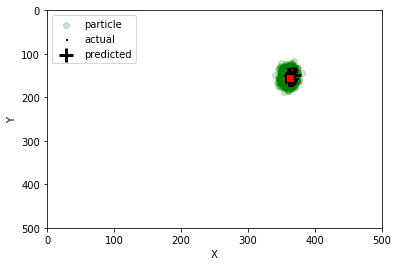

104.55694887231643


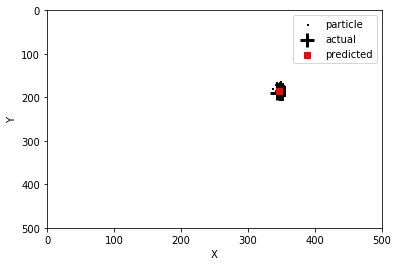

1.0040332884860115


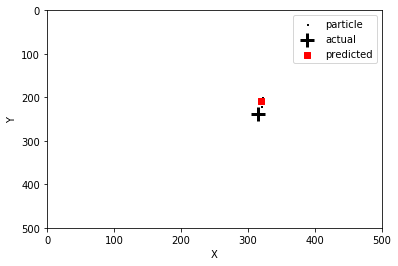

2.7362347864203023


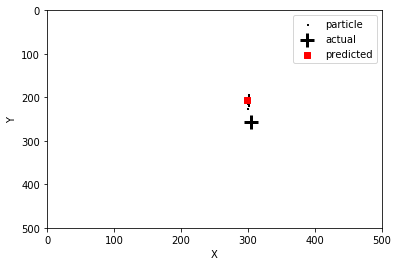

1.3529373198334447


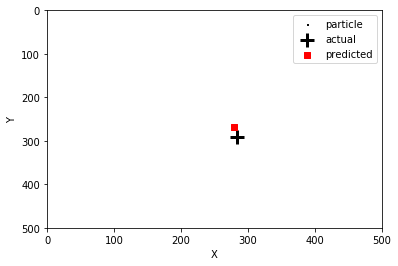

6.436053760200573


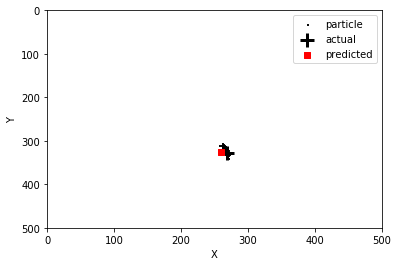

50.428540011000926


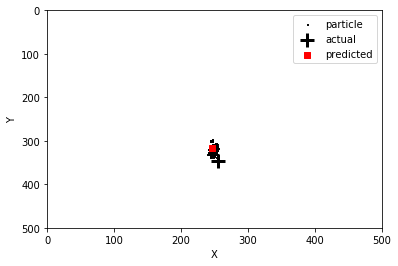

1.0412969910319954


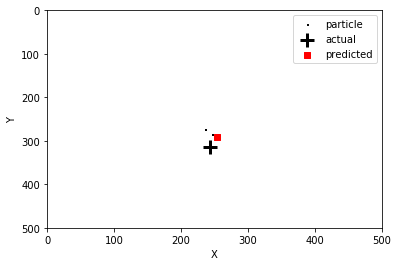

6.3375632839095


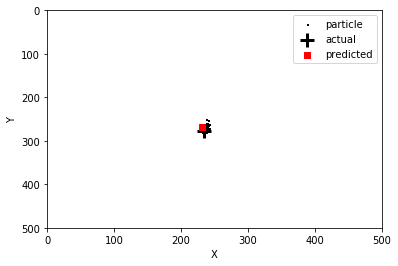

10.153495187010805


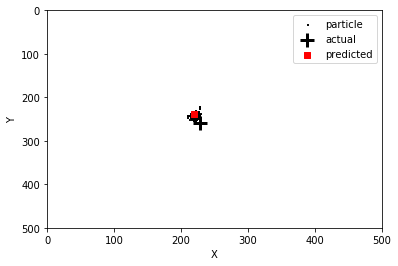

6.45818621653944


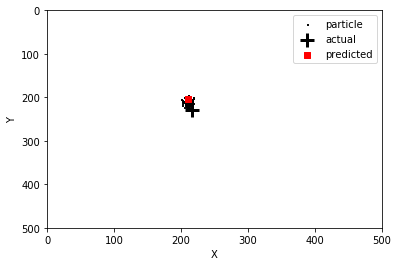

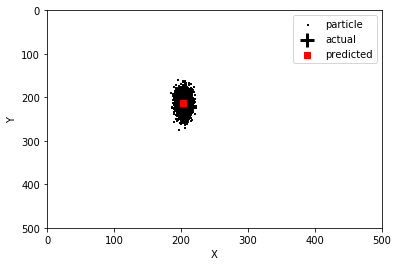

1.2370896549557144


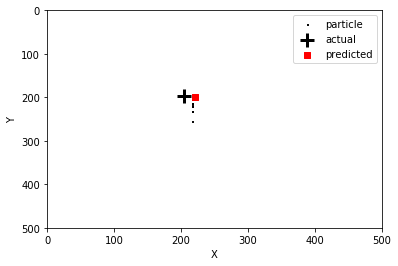

18.59817515740779


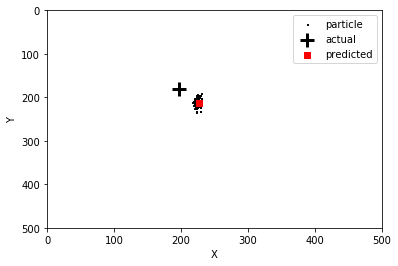

In [28]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
measurements = zip(X,Y)
global xs 

def run_pf1(N, iters=14, sensor_std_err=4, do_plot=True, plot_particles=True,xlim=(0, 500), ylim=(0, 500),initial=None):
    xs , vs = [], []
    p =1
    particles = create_gaussian_particles([360,152,-1*200,500], [5,10,10,100],N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color='g')
    for i in range(iters):
        predict(particles,[5,15,10,100]) #process noise
        gt = [x_gt[i],y_gt[i]]
        if i is not 11:    
            meas = [X[p], Y[p]]
            p += 1
            weights = update(particles, meas,weights,10,45)
            print(neff(weights))
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)
        vs.append(var)
        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(gt[0], gt[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
        plt.legend(['particle','actual','predicted'])
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.xlim([0 ,500])
        plt.ylim([0, 500])
        plt.gca().invert_yaxis()
        plt.show()
    
    #plt.show()
    
    return xs,vs

from numpy.random import seed

seed(20) 
X_hat,vs = run_pf1(N=3000, plot_particles=True)

In [29]:
X_hats ,Y_hats, Vx_hats,Vy_hats = [],[],[],[]
X_hats.append(X[0])
Y_hats.append(Y[0])
Vy_hats.append(500)
for i in range(len(X_hat)):
    X_hats.append(X_hat[i][0])
    Y_hats.append(X_hat[i][1])
    Vx_hats.append(X_hat[i][2])
    Vy_hats.append(X_hat[i][3])

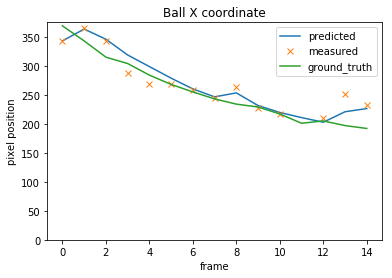

In [30]:
meas_X = []
p=0
for k in range(0,len(X)+1):
    if k in no_meas_idx:
        meas_X.append(np.nan)
    else:
        meas_X.append(X[p])
        p= p+1
plt.plot(X_hats)
plt.title("Ball X coordinate")
plt.xlabel("frame")
plt.ylabel("pixel position")
plt.ylim([0 ,375])
plt.plot(meas_X, 'x')

plt.plot(x_gt)
plt.legend(["predicted","measured","ground_truth"])
plt.show()

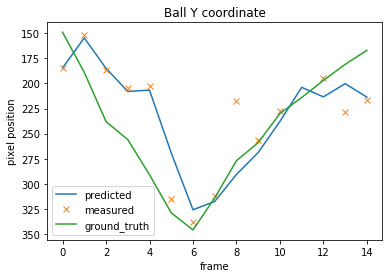

In [31]:
meas_Y = []
p=0
for k in range(0,len(X)+ len(no_meas_idx)):
    if k in no_meas_idx:
        meas_Y.append(np.nan)
    else:
        meas_Y.append(Y[p])
        p= p+1
plt.gca().invert_yaxis()
plt.plot(Y_hats)
plt.plot(meas_Y, 'x')


plt.plot(y_gt)
plt.title("Ball Y coordinate")
plt.xlabel("frame")
plt.ylabel("pixel position")
plt.legend(["predicted","measured","ground_truth"])
plt.show()

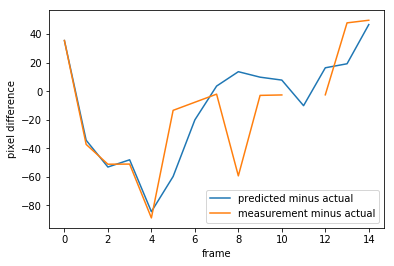

In [32]:
diffs_y = [(Y_hats[i] - y_gt[i]) for i in range(len(y_gt))]
plt.plot(diffs_y)

diffs_y_meas = [(meas_Y[i] - y_gt[i]) for i in range(len(y_gt)) ]

plt.plot(diffs_y_meas)
#plt.xlim([0,6])
plt.ylabel("pixel difference")
plt.xlabel("frame")
plt.legend(["predicted minus actual","measurement minus actual"])
plt.show()

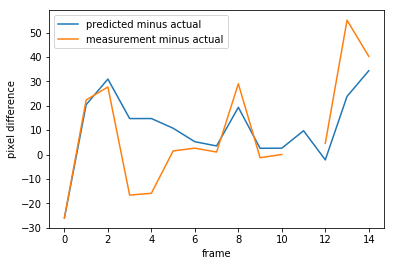

In [33]:
diffs_x = [(X_hats[i] - x_gt[i]) for i in range(len(y_gt))]
plt.plot(diffs_x)

diffs_x_meas = [(meas_X[i] - x_gt[i]) for i in range(len(y_gt)) ]

plt.plot(diffs_x_meas)
#plt.ylim([0,70])
plt.ylabel("pixel difference")
plt.xlabel("frame")
plt.legend(["predicted minus actual","measurement minus actual"])
plt.show()

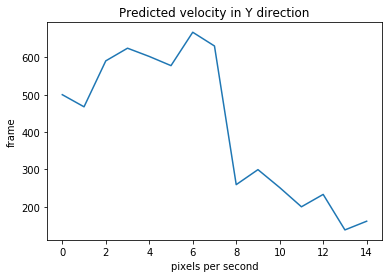

In [34]:
plt.plot(Vy_hats)
plt.ylabel("frame")
plt.xlabel("pixels per second")
plt.title("Predicted velocity in Y direction")
plt.show()